Sample problem: translate place-value demimals to the Roman numerals (a very simple, exact "language translation" task).

In [10]:
import roman

In [13]:
are_they_distinct = {roman.toRoman(i + 1) for i in range(3000)}
len(are_they_distinct)

3000

In [14]:
for i in range(3000):
    assert roman.fromRoman(roman.toRoman(i + 1)) == i + 1

In [15]:
max(len(roman.toRoman(i + 1)) for i in range(3000))

14

I don't think I need to use an Embedding for this.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import torch.nn

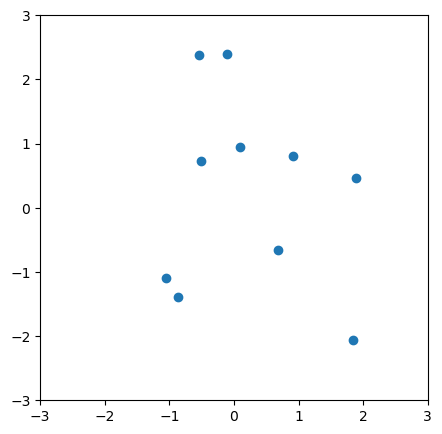

In [101]:
fig, ax = plt.subplots(figsize=(5, 5))

embed = torch.nn.Embedding(10, 2)
positions = embed(torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int64)).detach().numpy()

ax.scatter(positions[:, 0], positions[:, 1])

ax.axis([-3, 3, -3, 3])

None

In [105]:
list(embed.parameters())

[Parameter containing:
 tensor([[ 1.8459, -2.0616],
         [ 0.6757, -0.6624],
         [ 1.8821,  0.4654],
         [-0.8736, -1.3912],
         [ 0.9199,  0.8077],
         [-0.5372,  2.3746],
         [-1.0575, -1.1010],
         [-0.5163,  0.7277],
         [ 0.0883,  0.9409],
         [-0.1030,  2.3991]], requires_grad=True)]